# LSTM을 이용한 금 선물 가격 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, index_col="Date", parse_dates=True)
    return df

def split_data(df, train_ratio=0.8, val_ratio=0.1):
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size : train_size + val_size]
    test_df = df.iloc[train_size + val_size :]
    return train_df, val_df, test_df

In [3]:
def create_scaler(train_df):
    scaler = {}
    for col in train_df.columns:
        scaler[col] = {"min": train_df[col].min(), "max": train_df[col].max()}
    return scaler

def scale_data(data, scaler):
    scaled_data = data.copy()
    for col in data.columns:
        min_val = scaler[col]["min"]
        max_val = scaler[col]["max"]
        scaled_data[col] = (data[col] - min_val) / (max_val - min_val)
    return scaled_data

In [4]:
def create_multivariate_sequences(data, target_col, seq_length):
    xs, ys = [], []
    data_np = data.values
    target_idx = data.columns.get_loc(target_col)

    for i in range(len(data_np) - seq_length):
        x = data_np[i : i + seq_length]
        y = data_np[i + seq_length, target_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

In [5]:
def create_data_loaders(X_train, y_train, X_val, y_val, batch_size):
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).float()
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [6]:
class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 
        return out

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path="checkpoint.pt"):
        self.patience, self.verbose, self.delta, self.path = (
            patience,
            verbose,
            delta,
            path,
        )
        self.counter, self.best_score, self.early_stop, self.val_loss_min = (
            0,
            None,
            False,
            np.inf,
        )

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(
    model, train_loader, val_loader, device, num_epochs, learning_rate, patience=10
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for each in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                output = model(batch_X)
                val_losses.append(criterion(output, batch_y).item())

        val_loss = np.mean(val_losses)
        print(f"Epoch [{each+1} / {num_epochs}], Val: {val_loss}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early Stop")
            break
    
    model.load_state_dict(torch.load("checkpoint.pt"))
    return model

In [8]:
def inverse_scale_data(data, scaler, target_col):
    min_val = scaler[target_col]["min"]
    max_val = scaler[target_col]["max"]
    return data * (max_val - min_val) + min_val

In [9]:
def evaluate_and_visualize(
    model, X_test, y_test, test_df, scaler, target_column, seq_length, device
):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.to(device)).cpu().numpy()

    predicted_prices = inverse_scale_data(test_outputs, scaler, target_column)
    actual_prices = inverse_scale_data(y_test.numpy(), scaler, target_column)

    plt.figure(figsize=(15, 7))
    plt.title(f"Futures Gold Price Prediction (LSTM)")
    plt.plot(
        test_df.index[seq_length:], actual_prices, label="Actual Price", color="blue"
    )
    plt.plot(
        test_df.index[seq_length:],
        predicted_prices,
        label="Predicted Price",
        color="red",
        linestyle="--",
    )
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_prices, actual_prices

In [10]:
file_path = "data/stock_bond_futures_data.csv"
target_col = "Futures_Gold"
seq_length = 30
batch_size = 32
num_epochs = 100
learning_rate = 0.001
patience = 10

In [11]:
df = load_data(file_path)
train_df, val_df, test_df = split_data(df)

In [12]:
scaler = create_scaler(train_df)
train_scaled = scale_data(train_df,scaler)
val_scaled = scale_data(val_df,scaler)
test_scaled = scale_data(test_df,scaler)

In [13]:
X_train, y_train = create_multivariate_sequences(train_scaled, target_col, seq_length)
X_val, y_val = create_multivariate_sequences(val_scaled, target_col, seq_length)
X_test, y_test = create_multivariate_sequences(test_scaled, target_col, seq_length)

In [14]:
train_loader, val_loader = create_data_loaders(X_train, y_train, X_val, y_val, batch_size)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
## 데이터 불러오기 끝

In [15]:
model = SequenceModel(input_size=X_train.shape[2]).to(device)
trained_model = train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, patience)

Epoch [1 / 100], Val: 0.05861781992846065
Validation loss decreased (inf --> 0.058618). Saving model...
Epoch [2 / 100], Val: 0.0019126041685619082
Validation loss decreased (0.058618 --> 0.001913). Saving model...
Epoch [3 / 100], Val: 0.0011636117964776026
Validation loss decreased (0.001913 --> 0.001164). Saving model...
Epoch [4 / 100], Val: 0.0009990915455596729
Validation loss decreased (0.001164 --> 0.000999). Saving model...
Epoch [5 / 100], Val: 0.0005280546999226013
Validation loss decreased (0.000999 --> 0.000528). Saving model...
Epoch [6 / 100], Val: 0.0020275072990140566
EarlyStopping counter: 1 out of 10
Epoch [7 / 100], Val: 0.00042203129042819556
Validation loss decreased (0.000528 --> 0.000422). Saving model...
Epoch [8 / 100], Val: 0.0003818608268678266
Validation loss decreased (0.000422 --> 0.000382). Saving model...
Epoch [9 / 100], Val: 0.00037845405272997194
Validation loss decreased (0.000382 --> 0.000378). Saving model...
Epoch [10 / 100], Val: 0.0005507189281

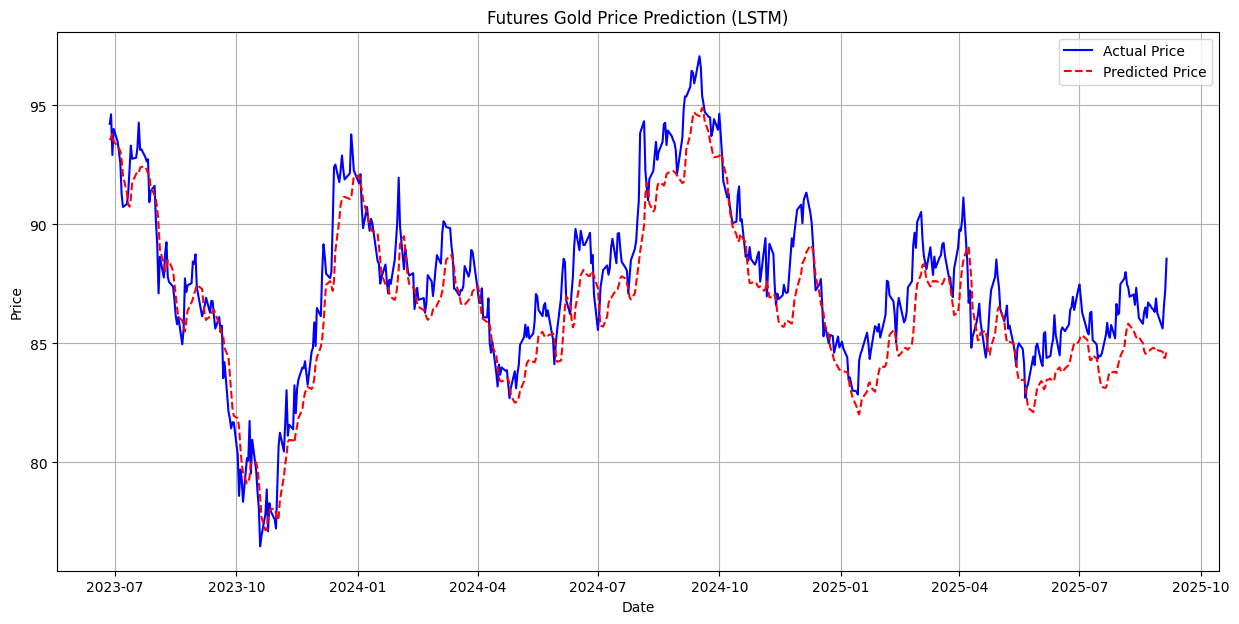

(array([[93.54152135],
        [93.651858  ],
        [93.80524803],
        [93.48611508],
        [93.29107286],
        [93.0867445 ],
        [92.72371879],
        [92.06388985],
        [91.33106053],
        [90.84071541],
        [90.74786381],
        [91.10509642],
        [91.75860351],
        [92.12645405],
        [92.18087552],
        [92.14522463],
        [92.37557405],
        [92.42544167],
        [92.40983697],
        [92.3045763 ],
        [92.1586152 ],
        [92.07654016],
        [91.61303235],
        [91.22332465],
        [91.04427378],
        [90.65514771],
        [90.01873904],
        [88.94524347],
        [88.36718553],
        [88.03091121],
        [88.13208729],
        [88.49522206],
        [88.44192748],
        [88.05770555],
        [87.55311065],
        [87.02363151],
        [86.51875572],
        [86.11368126],
        [85.96249214],
        [85.67428439],
        [85.5003756 ],
        [85.93438915],
        [86.37290697],
        [86

In [16]:
evaluate_and_visualize(trained_model, 
                       X_test_tensor, 
                       y_test_tensor, 
                       test_df,
                       scaler,
                       target_col,
                       seq_length,
                       device)